# Detailed features analysis and processing selection

In [144]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Data loading

In [2]:
# Data paths
DATA = "../../data/orginal/Org-Retweeted-Vectors_preproc.csv"

TRAIN = "../../data/intermediary/data_split/train_id_str.txt"
VAL = "../../data/intermediary/data_split/val_id_str.txt"
TEST = "../../data/intermediary/data_split/test_id_str.txt"

In [3]:
data = pd.read_csv(DATA, parse_dates=["created_at"]).iloc[:, 1:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214670 entries, 0 to 214669
Data columns (total 59 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   id_str                                214670 non-null  int64              
 1   created_at                            214670 non-null  datetime64[ns, UTC]
 2   full_text                             214670 non-null  object             
 3   retweet_count                         214670 non-null  float64            
 4   favorite_count                        214670 non-null  float64            
 5   entities.hashtags                     214670 non-null  object             
 6   entities.urls                         214670 non-null  bool               
 7   entities.media                        214670 non-null  bool               
 8   user_id_str                           214670 non-null  int64              
 9   user

In [4]:
with open(TRAIN) as f:
    train_ids = f.read().splitlines()
len(train_ids)

159544

In [5]:
with open(VAL) as f:
    val_ids = f.read().splitlines()
len(val_ids)

19943

In [6]:
with open(TEST) as f:
    test_ids = f.read().splitlines()
len(test_ids)

19944

# Labels

In [7]:
def retweet_categories(retweet_count):
    if retweet_count == 1:
        return 0
    elif retweet_count >= 2:
        return 1    
    else:
        raise ValueError

data["retweet_label"] = data.retweet_count.map(retweet_categories)

# Training and validation data

In [8]:
data = data.astype({"id_str": str})
data_train = data[data.id_str.isin(train_ids)]
print(len(data_train))

data_val = data[data.id_str.isin(val_ids)]
print(len(data_val))

data_test = data[data.id_str.isin(test_ids)]
print(len(data_test))

159544
19943
19944


# Label exploration

In [9]:
train_labels = data_train["retweet_label"].values
print(len(train_labels))

val_labels = data_val["retweet_label"].values
print(len(val_labels))

test_labels = data["retweet_label"].values
print(len(test_labels))

159544
19943
214670


[Text(0, 0.5, 'Percent')]

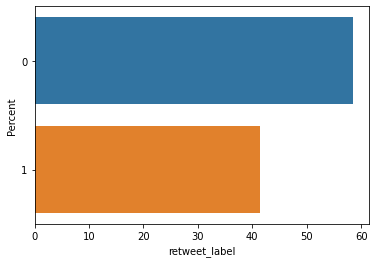

In [10]:
# https://github.com/mwaskom/seaborn/issues/1027
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=data_train[["retweet_label"]],
    estimator=lambda x: len(x) / len(data_train) * 100,
    orient="h")
ax.set(ylabel="Percent")

[Text(0, 0.5, 'Percent')]

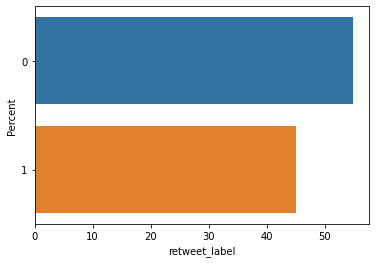

In [11]:
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=data_val[["retweet_label"]],
    estimator=lambda x: len(x) / len(data_val) * 100,
    orient="h")
ax.set(ylabel="Percent")

# Feature exploration, preparation, and selection

In [12]:
data_train.head()

,id_str,created_at,full_text,retweet_count,favorite_count,entities.hashtags,entities.urls,entities.media,user_id_str,user.screen_name,...,users_reply_out_degree,users_reply_in_strength,users_reply_out_strength,users_reply_eigenvector_in,users_reply_eigenvector_out,users_reply_katz_in,users_reply_katz_out,users_reply_clustering,users_reply_louvian_class,retweet_label
0,1339076855064915968,2020-12-16 05:16:15+00:00,"user adem aga mešić je bio hrvat, muslimanske ...",1.0,7.0,[],False,False,1252294810863636480,K80spl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1337506645904142336,2020-12-11 21:16:48+00:00,"user janša je dobar, al debelo kasni za tuđman...",4.0,28.0,[],True,False,1252294810863636480,K80spl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1335934602532298752,2020-12-07 13:10:04+00:00,"user lagano se uvodi diskriminacija, sve ka ne...",1.0,1.0,[],True,False,1252294810863636480,K80spl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1334842452096786432,2020-12-04 12:50:15+00:00,user url,1.0,7.0,[],False,True,1252294810863636480,K80spl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,1333647712064057088,2020-12-01 05:42:47+00:00,2 user url,1.0,5.0,[],False,True,1252294810863636480,K80spl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Hashtags

<AxesSubplot:xlabel='retweet_label', ylabel='number_of_hashtags'>

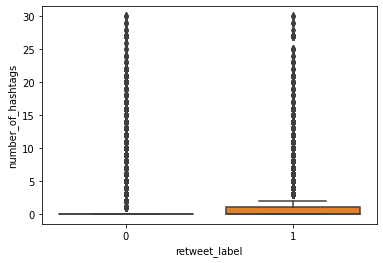

In [13]:
sns.boxplot(
    x="retweet_label",
    y="number_of_hashtags",
    data=data_train[["number_of_hashtags", "retweet_label"]],
    )

In [14]:
data["log1p_num_hashtags"] = data["number_of_hashtags"].map(np.log1p)
data_train = data[data.id_str.isin(train_ids)]

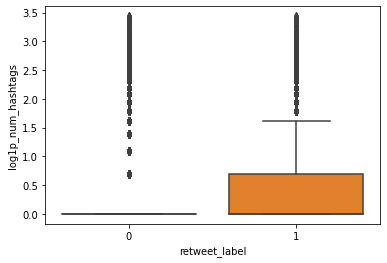

In [15]:
ax = sns.boxplot(
    x="retweet_label",
    y="log1p_num_hashtags",
    data=data_train[["log1p_num_hashtags", "retweet_label"]],
    )

In [16]:
data_train[data_train.retweet_label==1][["log1p_num_hashtags"]].describe()

,log1p_num_hashtags
count,66078.000000
mean,0.289077
std,0.534583
min,0.000000
25%,0.000000
50%,0.000000
75%,0.693147
max,3.433987


In [17]:
data_train[data_train.retweet_label==0][["log1p_num_hashtags"]].describe()

,log1p_num_hashtags
count,93466.000000
mean,0.237206
std,0.501467
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.433987


In [18]:
c = Counter(data_train.number_of_hashtags)
c.most_common()

[(0, 121190),
 (1, 18492),
 (2, 8636),
 (3, 5026),
 (4, 2330),
 (5, 1236),
 (6, 661),
 (7, 659),
 (8, 304),
 (9, 187),
 (10, 124),
 (11, 97),
 (14, 95),
 (12, 78),
 (16, 71),
 (27, 50),
 (13, 49),
 (21, 44),
 (20, 34),
 (15, 33),
 (22, 32),
 (17, 30),
 (19, 21),
 (18, 21),
 (23, 11),
 (24, 10),
 (25, 7),
 (30, 5),
 (29, 5),
 (28, 4),
 (26, 2)]

In [19]:
mutual_info_classif(data_train[["number_of_hashtags"]], train_labels)

array([0.00160173])

In [20]:
mutual_info_classif(data_train[["number_of_hashtags"]].gt(0), train_labels, discrete_features=True)

array([0.00144807])

In [21]:
mutual_info_classif(data_train[["log1p_num_hashtags"]], train_labels, discrete_features=False)

array([0.00046605])

In [22]:
scaler = StandardScaler()
transformed_num_hash = scaler.fit_transform(data_train[["number_of_hashtags"]])
mutual_info_classif(transformed_num_hash, train_labels, discrete_features=False)

array([0.00582546])

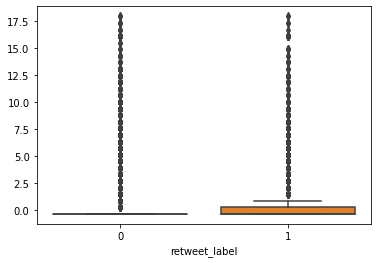

In [23]:
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_num_hash.squeeze(),    
    )

In [24]:
scaler = StandardScaler()
transformed_log_num_hash = scaler.fit_transform(data_train[["log1p_num_hashtags"]])
mutual_info_classif(transformed_log_num_hash, train_labels, discrete_features=False)

array([0.01089213])

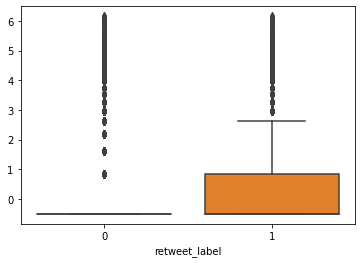

In [25]:
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_log_num_hash.squeeze(),    
    )

In [26]:
scaler = RobustScaler()
transformed_num_hash = scaler.fit_transform(data_train[["number_of_hashtags"]])
mutual_info_classif(transformed_num_hash, train_labels, discrete_features=False)

array([3.93316944e-05])

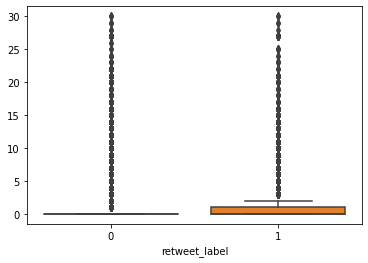

In [27]:
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_num_hash.squeeze(),    
    )

In [28]:
scaler = RobustScaler()
transformed_log_num_hash = scaler.fit_transform(data_train[["log1p_num_hashtags"]])
mutual_info_classif(transformed_log_num_hash, train_labels, discrete_features=False)


array([0.00245843])

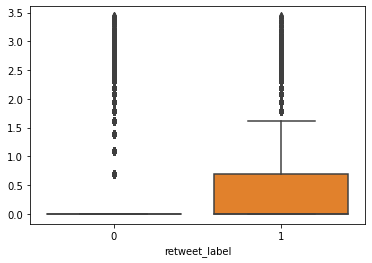

In [29]:
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_log_num_hash.squeeze(),    
    )

In [30]:
# use robust to have multiple features more similiar in scale
# feature interaction not captured by mutual information

## Urls

[Text(3.200000000000003, 0.5, 'Percent')]

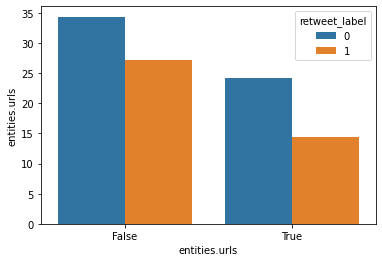

In [31]:
sns.barplot(
    x="entities.urls",
    y="entities.urls", 
    hue="retweet_label", 
    data=data_train[["entities.urls", "retweet_label"]],
    estimator=lambda x: len(x) / len(data_train) * 100,
    orient="v"
)
ax.set(ylabel="Percent")

In [32]:
mutual_info_classif(data_train[["entities.urls"]], train_labels, discrete_features=True)

array([0.00235975])

## Media

[Text(3.200000000000003, 0.5, 'Percent')]

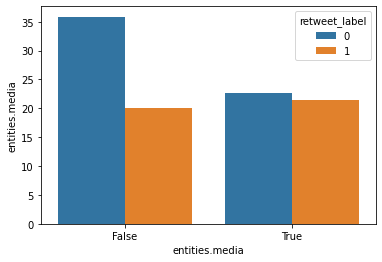

In [33]:
sns.barplot(
    x="entities.media",
    y="entities.media", 
    hue="retweet_label", 
    data=data_train[["entities.media", "retweet_label"]],
    estimator=lambda x: len(x) / len(data_train) * 100,
    orient="v"
)
ax.set(ylabel="Percent")

In [34]:
mutual_info_classif(data_train[["entities.media"]], train_labels, discrete_features=True)

array([0.00829649])

## Followers count

<AxesSubplot:xlabel='retweet_label', ylabel='user.followers_count'>

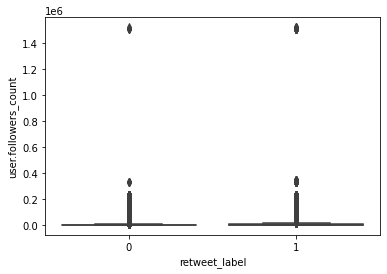

In [35]:
sns.boxplot(
    x="retweet_label",
    y="user.followers_count",
    data=data_train[["user.followers_count", "retweet_label"]],
    )

In [36]:
data_train[["user.followers_count"]].describe()

,user.followers_count
count,1.593020e+05
mean,1.223322e+04
std,4.453441e+04
min,0.000000e+00
25%,5.610000e+02
50%,1.627000e+03
75%,4.978000e+03
max,1.523336e+06


In [37]:
data_train[["user.followers_count"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159544 entries, 0 to 173184
Data columns (total 1 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user.followers_count  159302 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


<AxesSubplot:xlabel='retweet_label', ylabel='user.followers_count'>

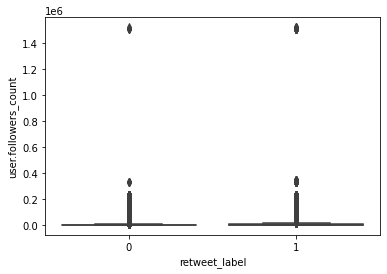

In [38]:
sns.boxplot(
    x="retweet_label",
    y="user.followers_count",
    data=data_train[["user.followers_count", "retweet_label"]][~data_train["user.followers_count"].isna()],
    )

242


[Text(0, 0.5, 'Percent')]

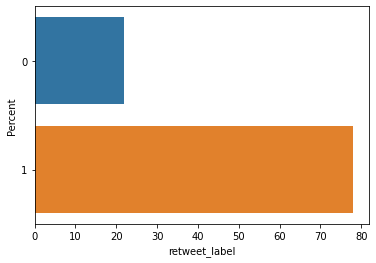

In [39]:
# None values are mostly 1
nan_data = data_train[["retweet_label"]][data_train["user.followers_count"].isna()]
print(len(nan_data))
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=nan_data,
    estimator=lambda x: len(x) / len(nan_data) * 100,
    orient="h")
ax.set(ylabel="Percent")

159302


[Text(0, 0.5, 'Percent')]

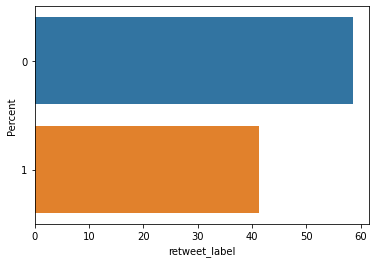

In [40]:
not_nan_data = data_train[~data_train["user.followers_count"].isna()]
print(len(not_nan_data))
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=not_nan_data,
    estimator=lambda x: len(x) / len(not_nan_data) * 100,
    orient="h")
ax.set(ylabel="Percent")

In [41]:
data_train[["user.followers_count"]].median()

user.followers_count    1627.0
dtype: float64

In [42]:
data_train[["user.followers_count"]][data_train.retweet_label == 1].median()

user.followers_count    2381.0
dtype: float64

In [43]:
data_train[["user.followers_count"]][data_train.retweet_label == 0].median()

user.followers_count    1185.0
dtype: float64

In [44]:
mutual_info_classif(not_nan_data[["user.followers_count"]], not_nan_data.retweet_label)

array([0.07808359])

In [45]:
data["log1p_followers_count"] = data["user.followers_count"].map(np.log1p)
data_train = data[data.id_str.isin(train_ids)]
not_nan_data = data_train[~data_train["user.followers_count"].isna()]

In [46]:
mutual_info_classif(not_nan_data[["log1p_followers_count"]], not_nan_data.retweet_label)

array([0.07805925])

In [47]:
scaler = StandardScaler()
transformed_log_followers = scaler.fit_transform(not_nan_data[["log1p_followers_count"]])
mutual_info_classif(transformed_log_followers, not_nan_data.retweet_label, discrete_features=False)

array([0.07895914])

<AxesSubplot:xlabel='retweet_label', ylabel='log1p_followers_count'>

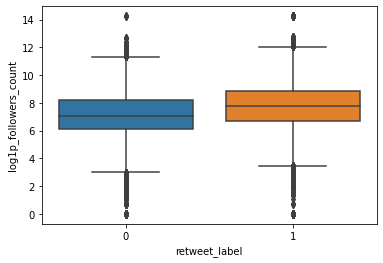

In [48]:
sns.boxplot(
    x="retweet_label",
    y="log1p_followers_count",
    data=not_nan_data[["log1p_followers_count", "retweet_label"]],
    )

In [49]:
scaler = RobustScaler()
transformed_followers = scaler.fit_transform(not_nan_data[["log1p_followers_count"]])
mutual_info_classif(transformed_followers, not_nan_data.retweet_label, discrete_features=False)

array([0.07798334])

<AxesSubplot:xlabel='retweet_label'>

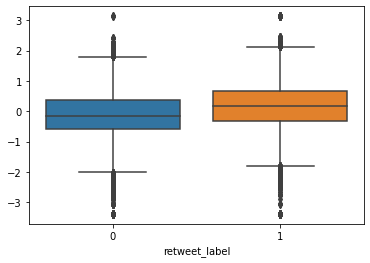

In [50]:
sns.boxplot(
    x=not_nan_data["retweet_label"],
    y=transformed_followers.squeeze(),
    data=not_nan_data[["log1p_followers_count", "retweet_label"]],
    )

## Friends count

<AxesSubplot:xlabel='retweet_label', ylabel='user.friends_count'>

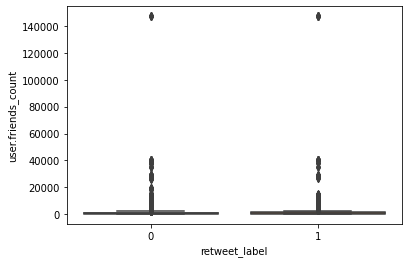

In [51]:
sns.boxplot(
    x="retweet_label",
    y="user.friends_count",
    data=data_train[["user.friends_count", "retweet_label"]],
    )

In [52]:
# do the same as for user.followers_count
data_train[["user.friends_count"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159544 entries, 0 to 173184
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user.friends_count  159302 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


242


[Text(0, 0.5, 'Percent')]

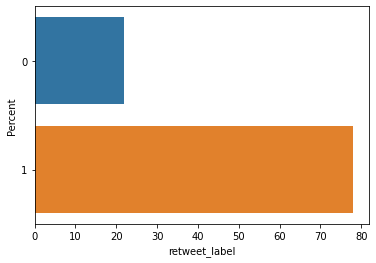

In [53]:
nan_data = data_train[["retweet_label"]][data_train["user.friends_count"].isna()]
print(len(nan_data))
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=nan_data,
    estimator=lambda x: len(x) / len(nan_data) * 100,
    orient="h")
ax.set(ylabel="Percent")

159302


[Text(0, 0.5, 'Percent')]

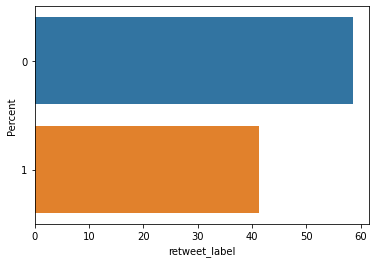

In [54]:
not_nan_data = data_train[~data_train["user.followers_count"].isna()]
print(len(not_nan_data))
ax = sns.barplot(
    x="retweet_label",
    y="retweet_label",
    data=not_nan_data,
    estimator=lambda x: len(x) / len(not_nan_data) * 100,
    orient="h")
ax.set(ylabel="Percent")

In [55]:
mutual_info_classif(not_nan_data[["user.friends_count"]], not_nan_data.retweet_label)

array([0.05986645])

In [56]:
data["log1p_friends_count"] = data["user.friends_count"].map(np.log1p)
data_train = data[data.id_str.isin(train_ids)]
not_nan_data = data_train[~data_train["user.friends_count"].isna()]

In [57]:
mutual_info_classif(not_nan_data[["log1p_friends_count"]], not_nan_data.retweet_label)

array([0.06023797])

In [58]:
scaler = RobustScaler()
transformed_friends = scaler.fit_transform(not_nan_data[["log1p_friends_count"]])
mutual_info_classif(transformed_friends, not_nan_data.retweet_label, discrete_features=False)

array([0.06137091])

<AxesSubplot:xlabel='retweet_label'>

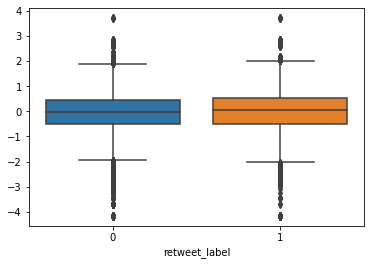

In [59]:
sns.boxplot(
    x=not_nan_data["retweet_label"],
    y=transformed_friends.squeeze(),
    data=not_nan_data[["log1p_friends_count", "retweet_label"]],
    )

## Statuses count

<AxesSubplot:xlabel='retweet_label', ylabel='user.statuses_count'>

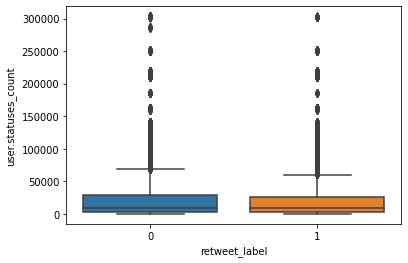

In [60]:
# like followers and friend counts
sns.boxplot(
    x="retweet_label",
    y="user.statuses_count",
    data=data_train[["user.statuses_count", "retweet_label"]],
    )

In [61]:
data_train[["user.statuses_count"]].describe()

,user.statuses_count
count,159302.000000
mean,22727.025298
std,32910.607943
min,1.000000
25%,3197.000000
50%,9754.000000
75%,29394.000000
max,303423.000000


In [62]:
data_train[["user.statuses_count"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159544 entries, 0 to 173184
Data columns (total 1 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user.statuses_count  159302 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


In [63]:
not_nan_data = data_train[~data_train["user.statuses_count"].isna()]

In [64]:
mutual_info_classif(not_nan_data[["user.statuses_count"]], not_nan_data.retweet_label)

array([0.08318722])

In [65]:
data["log1p_statuses_count"] = data["user.statuses_count"].map(np.log1p)
data_train = data[data.id_str.isin(train_ids)]
not_nan_data = data_train[~data_train["user.statuses_count"].isna()]

In [66]:
scaler = RobustScaler()
transformed_statuses = scaler.fit_transform(not_nan_data[["log1p_statuses_count"]])
mutual_info_classif(transformed_statuses, not_nan_data.retweet_label, discrete_features=False)

array([0.08335872])

<AxesSubplot:xlabel='retweet_label'>

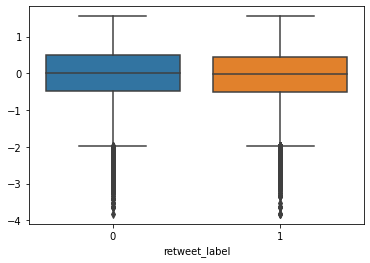

In [67]:
sns.boxplot(
    x=not_nan_data["retweet_label"],
    y=transformed_statuses.squeeze(),
    data=not_nan_data[["log1p_followers_count", "retweet_label"]],
    )

## Users in net

[Text(17.200000000000003, 0.5, 'Percent')]

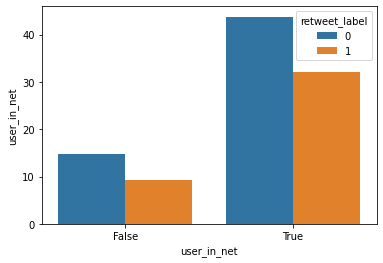

In [68]:
sns.barplot(
    x="user_in_net",
    y="user_in_net", 
    hue="retweet_label", 
    data=data_train[["user_in_net", "retweet_label"]],
    estimator=lambda x: len(x) / len(data_train) * 100,
    orient="v"
)
ax.set(ylabel="Percent")

In [69]:
mutual_info_classif(data_train[["user_in_net"]], train_labels, discrete_features=True)

array([0.00055436])

## Covid keywords flag

[Text(17.200000000000003, 0.5, 'Percent')]

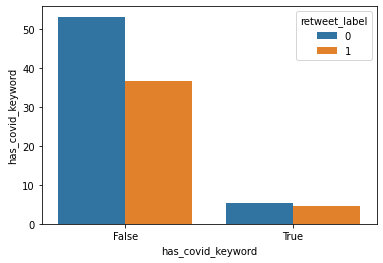

In [70]:
sns.barplot(
    x="has_covid_keyword",
    y="has_covid_keyword", 
    hue="retweet_label", 
    data=data_train[["has_covid_keyword", "retweet_label"]],
    estimator=lambda x: len(x) / len(data_train) * 100,
    orient="v"
)
ax.set(ylabel="Percent")

In [71]:
mutual_info_classif(data_train[["has_covid_keyword"]], train_labels, discrete_features=True)

array([0.00052236])

## Mentioned users count

<AxesSubplot:xlabel='retweet_label', ylabel='number_of_mentioned_users'>

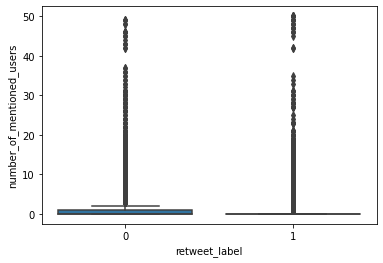

In [97]:
sns.boxplot(
    x="retweet_label",
    y="number_of_mentioned_users",
    data=data_train,
    )

In [98]:
mutual_info_classif(data_train[["number_of_mentioned_users"]], train_labels)

array([0.00365851])

[0.00422891]


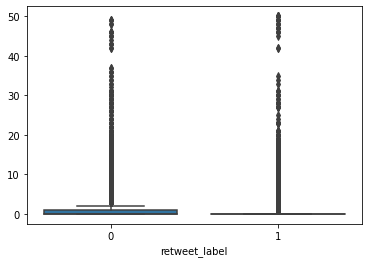

In [101]:
scaler = RobustScaler()
transformed_num_mentioned = scaler.fit_transform(data_train[["number_of_mentioned_users"]])
print(mutual_info_classif(transformed_num_mentioned, train_labels, discrete_features=False))
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_num_mentioned.squeeze(),    
    )

In [102]:
data["log1p_num_mentioned"] = data["number_of_mentioned_users"].map(np.log1p)
data_train = data[data.id_str.isin(train_ids)]

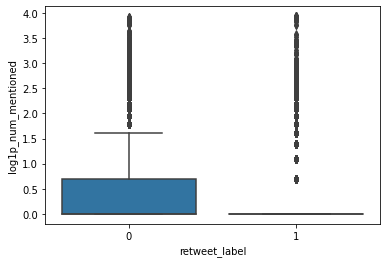

In [103]:
ax = sns.boxplot(
    x="retweet_label",
    y="log1p_num_mentioned",
    data=data_train[["log1p_num_mentioned", "retweet_label"]],
    )

In [104]:
mutual_info_classif(data_train[["log1p_num_mentioned"]], train_labels)

array([0.00315645])

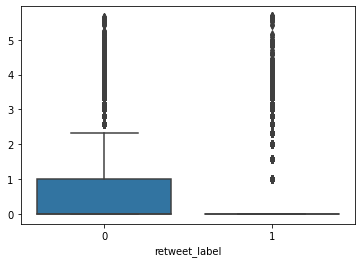

In [105]:
scaler = RobustScaler()
transformed_num_mentioned = scaler.fit_transform(data_train[["log1p_num_mentioned"]])
ax = sns.boxplot(
    x=data_train["retweet_label"],
    y=transformed_num_mentioned.squeeze(),    
    )

# Network measures

## Following users

In [73]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159544 entries, 0 to 173184
Data columns (total 64 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   id_str                                159544 non-null  object             
 1   created_at                            159544 non-null  datetime64[ns, UTC]
 2   full_text                             159544 non-null  object             
 3   retweet_count                         159544 non-null  float64            
 4   favorite_count                        159544 non-null  float64            
 5   entities.hashtags                     159544 non-null  object             
 6   entities.urls                         159544 non-null  bool               
 7   entities.media                        159544 non-null  bool               
 8   user_id_str                           159544 non-null  int64              
 9   user

In [74]:
cols = data_train.columns
following_cols = [
    col for col in cols if col.startswith("folowing_users_graph")
    and not col.endswith("louvian_class")]
print(following_cols)

['folowing_users_graph_in_degree', 'folowing_users_graph_out_degree', 'folowing_users_graph_in_strength', 'folowing_users_graph_out_strength', 'folowing_users_graph_eigenvector_in', 'folowing_users_graph_eigenvector_out', 'folowing_users_graph_katz_in', 'folowing_users_graph_katz_out', 'folowing_users_graph_clustering']


In [75]:
data_train[following_cols].describe()

,folowing_users_graph_in_degree,folowing_users_graph_out_degree,folowing_users_graph_in_strength,folowing_users_graph_out_strength,folowing_users_graph_eigenvector_in,folowing_users_graph_eigenvector_out,folowing_users_graph_katz_in,folowing_users_graph_katz_out,folowing_users_graph_clustering
count,121162.000000,121162.000000,121162.000000,121162.000000,121162.000000,121162.000000,121162.000000,121162.000000,121162.000000
mean,0.018710,0.003333,0.003333,0.003333,0.003333,0.003333,-0.000092,0.001850,0.176875
std,0.060940,0.005386,0.005386,0.005386,0.005386,0.005386,0.019002,0.015677,0.159846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.079618,-0.090353,0.000000
25%,0.000776,0.000317,0.000317,0.000317,0.000317,0.000317,-0.009440,-0.004929,0.057424
50%,0.003103,0.001446,0.001446,0.001446,0.001446,0.001446,-0.000045,0.000279,0.138542
75%,0.011284,0.003985,0.003985,0.003985,0.003985,0.003985,0.009040,0.006936,0.254938
max,0.453276,0.047923,0.047923,0.047923,0.047923,0.047923,0.113453,0.084112,1.000000


In [76]:
following_data = data_train[following_cols + ["retweet_label"]]
following_data

,folowing_users_graph_in_degree,folowing_users_graph_out_degree,folowing_users_graph_in_strength,folowing_users_graph_out_strength,folowing_users_graph_eigenvector_in,folowing_users_graph_eigenvector_out,folowing_users_graph_katz_in,folowing_users_graph_katz_out,folowing_users_graph_clustering,retweet_label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
173180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
173181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
173182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
173183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [77]:
following_data = following_data.dropna()
following_data

,folowing_users_graph_in_degree,folowing_users_graph_out_degree,folowing_users_graph_in_strength,folowing_users_graph_out_strength,folowing_users_graph_eigenvector_in,folowing_users_graph_eigenvector_out,folowing_users_graph_katz_in,folowing_users_graph_katz_out,folowing_users_graph_clustering,retweet_label
134,0.000000,0.000071,0.000071,0.000071,0.000071,0.000071,-0.000045,-0.004022,1.000000,0
136,0.000000,0.000071,0.000071,0.000071,0.000071,0.000071,-0.000045,-0.004022,1.000000,0
137,0.000000,0.000071,0.000071,0.000071,0.000071,0.000071,-0.000045,-0.004022,1.000000,1
140,0.000000,0.000071,0.000071,0.000071,0.000071,0.000071,-0.000045,-0.004022,1.000000,0
141,0.000106,0.000035,0.000035,0.000035,0.000035,0.000035,-0.005204,-0.000950,0.250000,0
...,...,...,...,...,...,...,...,...,...,...
173143,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.004286,-0.000944,0.125541,0
173144,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.004286,-0.000944,0.125541,0
173145,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.004286,-0.000944,0.125541,0
173146,0.000741,0.000776,0.000776,0.000776,0.000776,0.000776,0.007208,0.003526,0.181717,0


In [78]:
# https://www.kaggle.com/ryanholbrook/mutual-information
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [79]:
mi_scores = make_mi_scores(following_data[following_cols], following_data["retweet_label"])
mi_scores

folowing_users_graph_katz_in            0.083263
folowing_users_graph_katz_out           0.080715
folowing_users_graph_clustering         0.077703
folowing_users_graph_in_degree          0.054843
folowing_users_graph_out_strength       0.035203
folowing_users_graph_out_degree         0.034803
folowing_users_graph_eigenvector_in     0.034457
folowing_users_graph_in_strength        0.034288
folowing_users_graph_eigenvector_out    0.034040
Name: MI Scores, dtype: float64

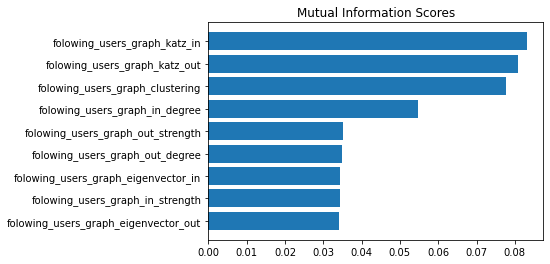

In [80]:
plot_mi_scores(mi_scores)

<AxesSubplot:xlabel='folowing_users_graph_katz_in', ylabel='Density'>

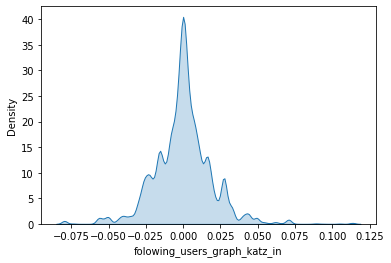

In [106]:
sns.kdeplot(following_data["folowing_users_graph_katz_in"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_katz_out', ylabel='Density'>

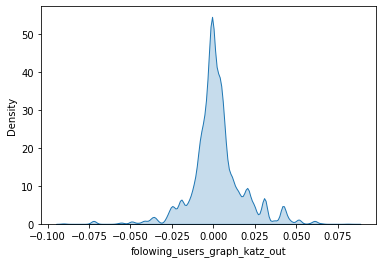

In [107]:
sns.kdeplot(following_data["folowing_users_graph_katz_out"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_clustering', ylabel='Density'>

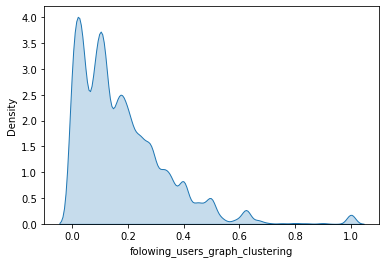

In [108]:
sns.kdeplot(following_data["folowing_users_graph_clustering"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_in_degree', ylabel='Density'>

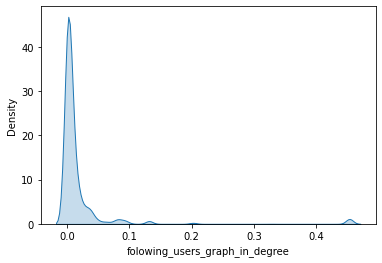

In [109]:
sns.kdeplot(following_data["folowing_users_graph_in_degree"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_out_degree', ylabel='Density'>

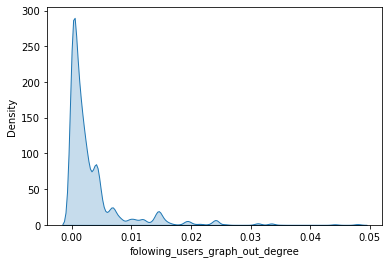

In [110]:
sns.kdeplot(following_data["folowing_users_graph_out_degree"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_out_strength', ylabel='Density'>

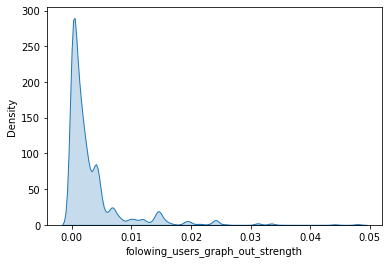

In [111]:
sns.kdeplot(following_data["folowing_users_graph_out_strength"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_in_strength', ylabel='Density'>

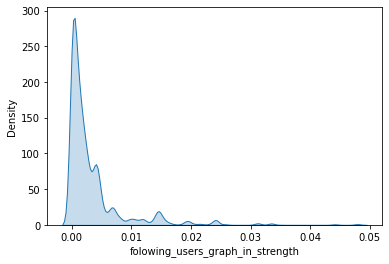

In [112]:
sns.kdeplot(following_data["folowing_users_graph_in_strength"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_eigenvector_in', ylabel='Density'>

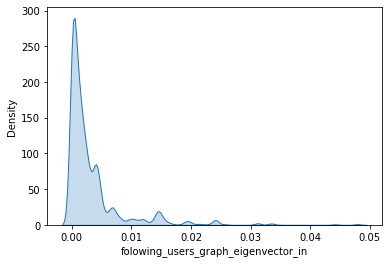

In [113]:
sns.kdeplot(following_data["folowing_users_graph_eigenvector_in"], shade=True)

<AxesSubplot:xlabel='folowing_users_graph_eigenvector_out', ylabel='Density'>

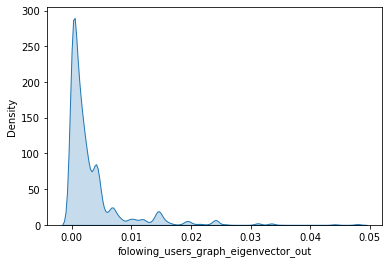

In [114]:
sns.kdeplot(following_data["folowing_users_graph_eigenvector_out"], shade=True)

In [145]:
scaler = PowerTransformer()
following_data_2 = following_data.copy()
following_data_2[following_cols] = scaler.fit_transform(following_data_2[following_cols])
following_data_2.describe()

,folowing_users_graph_in_degree,folowing_users_graph_out_degree,folowing_users_graph_in_strength,folowing_users_graph_out_strength,folowing_users_graph_eigenvector_in,folowing_users_graph_eigenvector_out,folowing_users_graph_katz_in,folowing_users_graph_katz_out,folowing_users_graph_clustering,retweet_label
count,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,1.211620e+05,121162.000000
mean,-6.005148e-17,9.383044e-18,9.383044e-18,9.383044e-18,9.383044e-18,9.383044e-18,1.876609e-18,1.876609e-18,-4.879183e-17,0.423375
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.494096
min,-8.759869e-01,-1.170546e+00,-1.170546e+00,-1.170546e+00,-1.170546e+00,-1.170546e+00,-4.534152e+00,-6.108196e+00,-1.593106e+00,0.000000
25%,-7.614688e-01,-9.390644e-01,-9.390644e-01,-9.390644e-01,-9.390644e-01,-9.390644e-01,-4.783658e-01,-4.271397e-01,-8.294815e-01,0.000000
50%,-4.409448e-01,-2.411161e-01,-2.411161e-01,-2.411161e-01,-2.411161e-01,-2.411161e-01,2.208801e-02,-9.368501e-02,-1.770234e-02,0.000000
75%,4.539375e-01,7.981516e-01,7.981516e-01,7.981516e-01,7.981516e-01,7.981516e-01,4.968099e-01,3.304367e-01,7.830225e-01,1.000000
max,2.534708e+00,2.106958e+00,2.106958e+00,2.106958e+00,2.106958e+00,2.106958e+00,5.373976e+00,5.079661e+00,2.406443e+00,1.000000


In [146]:
mi_scores = make_mi_scores(
    following_data_2[following_cols], following_data_2["retweet_label"])
mi_scores

folowing_users_graph_katz_in            0.083258
folowing_users_graph_katz_out           0.080905
folowing_users_graph_clustering         0.077411
folowing_users_graph_in_degree          0.055533
folowing_users_graph_in_strength        0.035017
folowing_users_graph_eigenvector_in     0.034973
folowing_users_graph_out_strength       0.033949
folowing_users_graph_out_degree         0.033617
folowing_users_graph_eigenvector_out    0.032877
Name: MI Scores, dtype: float64

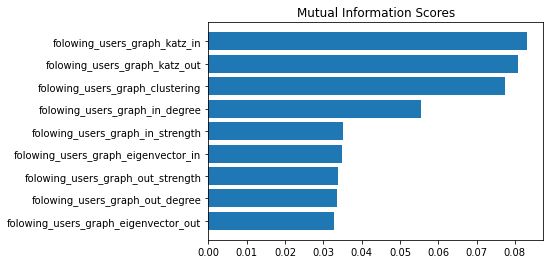

In [147]:
plot_mi_scores(mi_scores)

## tweets_keywords_3

In [81]:
tweets_keyword_cols = [
    col for col in cols if col.startswith("tweets_keywords_3")
    and not col.endswith("louvian_class")]
print(tweets_keyword_cols)

['tweets_keywords_3_in_degree', 'tweets_keywords_3_out_degree', 'tweets_keywords_3_in_strength', 'tweets_keywords_3_out_strength', 'tweets_keywords_3_eigenvector_in', 'tweets_keywords_3_eigenvector_out', 'tweets_keywords_3_katz_in', 'tweets_keywords_3_katz_out', 'tweets_keywords_3_clustering']


In [82]:
data_train[tweets_keyword_cols].describe()

,tweets_keywords_3_in_degree,tweets_keywords_3_out_degree,tweets_keywords_3_in_strength,tweets_keywords_3_out_strength,tweets_keywords_3_eigenvector_in,tweets_keywords_3_eigenvector_out,tweets_keywords_3_katz_in,tweets_keywords_3_katz_out,tweets_keywords_3_clustering
count,159544.000000,159544.000000,159544.000000,159544.000000,1.595440e+05,1.595440e+05,1.595440e+05,1.595440e+05,159544.000000
mean,0.000099,0.000082,1.683264,1.652407,1.009089e-04,3.063943e-05,3.063943e-05,3.063943e-05,0.100271
std,0.000331,0.000292,1.992630,1.937903,2.474287e-03,2.388861e-03,2.388861e-03,2.388861e-03,0.152828
min,0.000000,0.000000,0.000000,0.000000,-1.269521e-11,-6.583785e-16,-6.583785e-16,-6.583785e-16,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-8.923957e-21,-5.207019e-21,-5.207019e-21,-5.207019e-21,0.000000
50%,0.000000,0.000000,0.000000,0.000000,5.632779e-21,2.717378e-21,2.717378e-21,2.717378e-21,0.000000
75%,0.000050,0.000040,3.068966,3.062500,1.020161e-18,2.315054e-19,2.315054e-19,2.315054e-19,0.153551
max,0.009547,0.010043,49.000000,49.000000,2.306584e-01,3.779587e-01,3.779587e-01,3.779587e-01,0.666667


In [83]:
tw_keyword_data = data_train[tweets_keyword_cols + ["retweet_label"]]
tw_keyword_data

,tweets_keywords_3_in_degree,tweets_keywords_3_out_degree,tweets_keywords_3_in_strength,tweets_keywords_3_out_strength,tweets_keywords_3_eigenvector_in,tweets_keywords_3_eigenvector_out,tweets_keywords_3_katz_in,tweets_keywords_3_katz_out,tweets_keywords_3_clustering,retweet_label
0,0.000020,0.000010,3.250000,3.000000,-3.822953e-19,3.929396e-17,3.929396e-17,3.929396e-17,0.066667,0
1,0.000185,0.000276,3.081081,3.036364,-9.171450e-15,1.380202e-16,1.380202e-16,1.380202e-16,0.134376,1
2,0.000000,0.000000,0.000000,0.000000,5.758291e-21,-1.939377e-21,-1.939377e-21,-1.939377e-21,0.000000,0
3,0.000000,0.000000,0.000000,0.000000,-1.373809e-20,1.187222e-20,1.187222e-20,1.187222e-20,0.000000,0
5,0.000000,0.000000,0.000000,0.000000,1.511436e-20,4.341569e-21,4.341569e-21,4.341569e-21,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
173180,0.000000,0.000000,0.000000,0.000000,-1.646761e-20,-1.504003e-20,-1.504003e-20,-1.504003e-20,0.000000,1
173181,0.000000,0.000000,0.000000,0.000000,1.631822e-20,-4.484145e-21,-4.484145e-21,-4.484145e-21,0.000000,1
173182,0.000000,0.000000,0.000000,0.000000,-5.966634e-22,3.535969e-21,3.535969e-21,3.535969e-21,0.000000,1
173183,0.000005,0.000000,4.000000,0.000000,3.895844e-20,-1.345068e-20,-1.345068e-20,-1.345068e-20,0.000000,1


In [84]:
# all defined
tw_keyword_data = tw_keyword_data.dropna()
tw_keyword_data

,tweets_keywords_3_in_degree,tweets_keywords_3_out_degree,tweets_keywords_3_in_strength,tweets_keywords_3_out_strength,tweets_keywords_3_eigenvector_in,tweets_keywords_3_eigenvector_out,tweets_keywords_3_katz_in,tweets_keywords_3_katz_out,tweets_keywords_3_clustering,retweet_label
0,0.000020,0.000010,3.250000,3.000000,-3.822953e-19,3.929396e-17,3.929396e-17,3.929396e-17,0.066667,0
1,0.000185,0.000276,3.081081,3.036364,-9.171450e-15,1.380202e-16,1.380202e-16,1.380202e-16,0.134376,1
2,0.000000,0.000000,0.000000,0.000000,5.758291e-21,-1.939377e-21,-1.939377e-21,-1.939377e-21,0.000000,0
3,0.000000,0.000000,0.000000,0.000000,-1.373809e-20,1.187222e-20,1.187222e-20,1.187222e-20,0.000000,0
5,0.000000,0.000000,0.000000,0.000000,1.511436e-20,4.341569e-21,4.341569e-21,4.341569e-21,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
173180,0.000000,0.000000,0.000000,0.000000,-1.646761e-20,-1.504003e-20,-1.504003e-20,-1.504003e-20,0.000000,1
173181,0.000000,0.000000,0.000000,0.000000,1.631822e-20,-4.484145e-21,-4.484145e-21,-4.484145e-21,0.000000,1
173182,0.000000,0.000000,0.000000,0.000000,-5.966634e-22,3.535969e-21,3.535969e-21,3.535969e-21,0.000000,1
173183,0.000005,0.000000,4.000000,0.000000,3.895844e-20,-1.345068e-20,-1.345068e-20,-1.345068e-20,0.000000,1


In [85]:
mi_scores = make_mi_scores(tw_keyword_data[tweets_keyword_cols], tw_keyword_data["retweet_label"])
mi_scores

tweets_keywords_3_clustering         0.013529
tweets_keywords_3_in_strength        0.013471
tweets_keywords_3_out_strength       0.010025
tweets_keywords_3_in_degree          0.008622
tweets_keywords_3_out_degree         0.006472
tweets_keywords_3_eigenvector_in     0.003801
tweets_keywords_3_eigenvector_out    0.002447
tweets_keywords_3_katz_out           0.001140
tweets_keywords_3_katz_in            0.000000
Name: MI Scores, dtype: float64

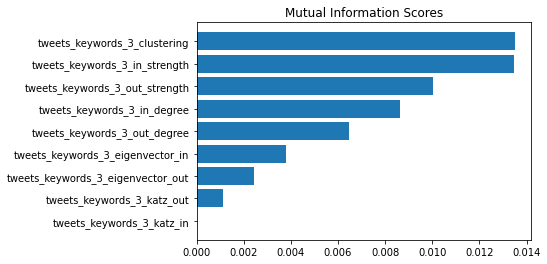

In [86]:
plot_mi_scores(mi_scores)

<AxesSubplot:xlabel='tweets_keywords_3_clustering', ylabel='Density'>

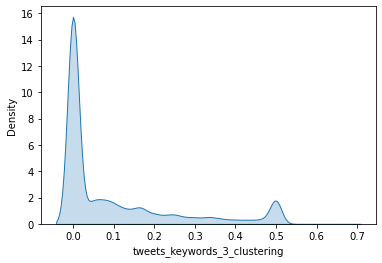

In [115]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_clustering"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_in_strength', ylabel='Density'>

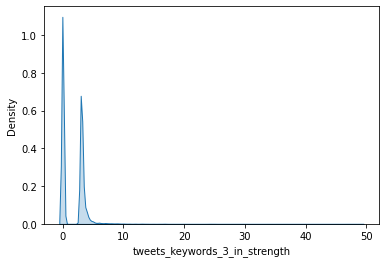

In [116]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_in_strength"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_out_strength', ylabel='Density'>

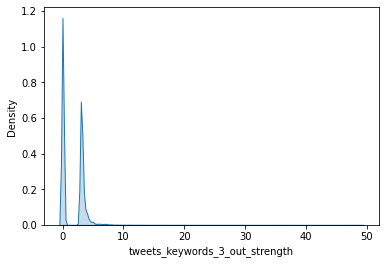

In [117]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_out_strength"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_in_degree', ylabel='Density'>

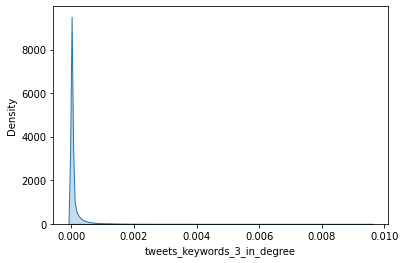

In [118]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_in_degree"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_out_degree', ylabel='Density'>

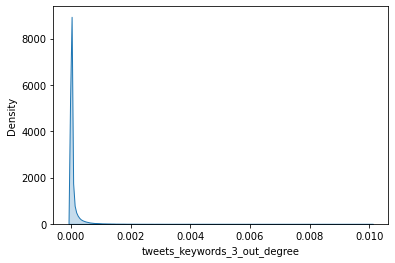

In [119]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_out_degree"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_eigenvector_in', ylabel='Density'>

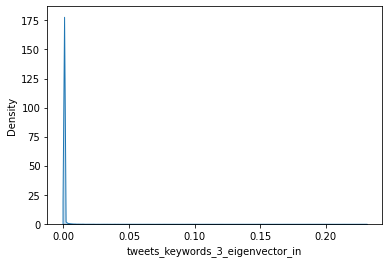

In [120]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_eigenvector_in"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_eigenvector_out', ylabel='Density'>

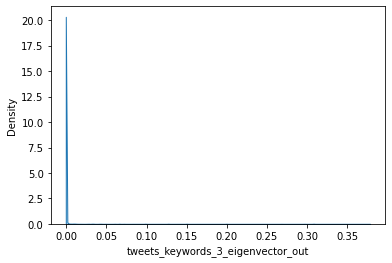

In [121]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_eigenvector_out"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_katz_in', ylabel='Density'>

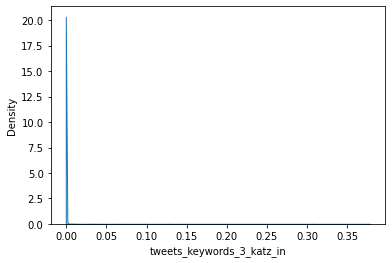

In [122]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_katz_in"], shade=True)

<AxesSubplot:xlabel='tweets_keywords_3_katz_out', ylabel='Density'>

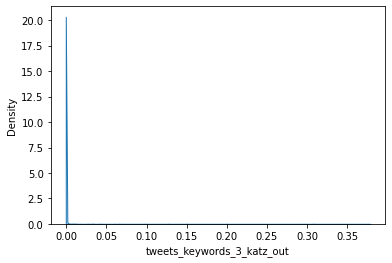

In [123]:
sns.kdeplot(tw_keyword_data["tweets_keywords_3_katz_out"], shade=True)

## users_mention

In [87]:
users_mention_cols = [
    col for col in cols if col.startswith("users_mention")
    and not col.endswith("louvian_class")]
print(users_mention_cols)

['users_mention_in_degree', 'users_mention_out_degree', 'users_mention_in_strength', 'users_mention_out_strength', 'users_mention_eigenvector_in', 'users_mention_eigenvector_out', 'users_mention_katz_in', 'users_mention_katz_out', 'users_mention_clustering']


In [88]:
data_train[users_mention_cols].describe()

,users_mention_in_degree,users_mention_out_degree,users_mention_in_strength,users_mention_out_strength,users_mention_eigenvector_in,users_mention_eigenvector_out,users_mention_katz_in,users_mention_katz_out,users_mention_clustering
count,41733.000000,41733.000000,41733.000000,41733.000000,4.173300e+04,4.173300e+04,41733.000000,41733.000000,41733.000000
mean,0.001729,0.000681,0.000681,0.000681,3.007106e-02,7.646358e-03,0.017717,-0.000203,0.060736
std,0.002640,0.001869,0.001869,0.001869,1.145800e-01,3.318544e-02,0.118116,0.009777,0.113037
min,0.000044,0.000000,0.000000,0.000000,-7.105053e-18,-3.032739e-19,-0.163928,-0.411001,0.000000
25%,0.000068,0.000000,0.000000,0.000000,1.351463e-18,-1.254515e-21,-0.000642,0.000159,0.000000
50%,0.000466,0.000000,0.000000,0.000000,1.517288e-06,6.429565e-21,0.000181,0.000159,0.030551
75%,0.002485,0.000639,0.000639,0.000639,7.135467e-04,1.829249e-05,0.001764,0.000159,0.061474
max,0.013489,0.027288,0.027288,0.027288,6.053705e-01,8.004620e-01,0.861832,0.197431,1.000000


In [89]:
users_mention_data = data_train[users_mention_cols + ["retweet_label"]].dropna()
users_mention_data

,users_mention_in_degree,users_mention_out_degree,users_mention_in_strength,users_mention_out_strength,users_mention_eigenvector_in,users_mention_eigenvector_out,users_mention_katz_in,users_mention_katz_out,users_mention_clustering,retweet_label
0,0.000444,0.000000,0.000000,0.000000,1.239823e-06,3.809265e-21,-0.009953,0.000159,0.022222,0
1,0.000355,0.000000,0.000000,0.000000,2.951882e-09,7.244525e-21,0.001115,0.000159,0.125000,1
2,0.001242,0.005546,0.005546,0.005546,2.334710e-08,1.079266e-02,0.000842,-0.049367,0.031011,0
3,0.003062,0.000000,0.000000,0.000000,6.958486e-05,-1.028446e-20,-0.024722,0.000159,0.031969,0
5,0.000821,0.002773,0.002773,0.002773,1.759077e-08,5.396328e-03,-0.000598,-0.024604,0.043283,0
...,...,...,...,...,...,...,...,...,...,...
173143,0.000044,0.000000,0.000000,0.000000,-6.103905e-19,9.961842e-21,0.000131,0.000159,0.000000,0
173144,0.000155,0.000229,0.000229,0.000229,2.544280e-07,4.346874e-07,-0.001901,0.000215,0.093831,0
173145,0.000114,0.000000,0.000000,0.000000,4.914751e-08,-6.704327e-22,0.000601,0.000159,0.007792,0
173167,0.000044,0.000000,0.000000,0.000000,1.309174e-19,-5.772001e-21,0.000123,0.000159,0.000000,1


In [90]:
mi_scores = make_mi_scores(
    users_mention_data[users_mention_cols], users_mention_data["retweet_label"])
mi_scores

users_mention_katz_in            0.093826
users_mention_eigenvector_in     0.080400
users_mention_clustering         0.061093
users_mention_in_degree          0.040468
users_mention_eigenvector_out    0.037050
users_mention_katz_out           0.036874
users_mention_out_strength       0.027055
users_mention_out_degree         0.025119
users_mention_in_strength        0.024515
Name: MI Scores, dtype: float64

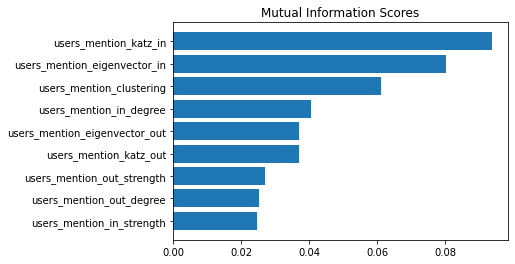

In [91]:
plot_mi_scores(mi_scores)

<AxesSubplot:xlabel='users_mention_katz_in', ylabel='Density'>

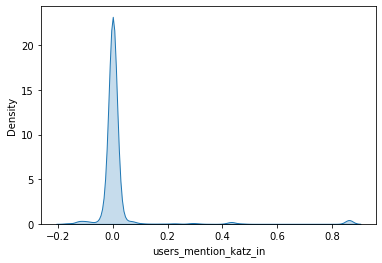

In [125]:
sns.kdeplot(users_mention_data["users_mention_katz_in"], shade=True)

<AxesSubplot:xlabel='users_mention_katz_out', ylabel='Density'>

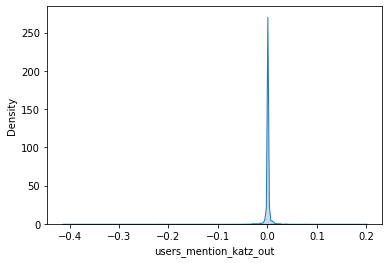

In [126]:
sns.kdeplot(users_mention_data["users_mention_katz_out"], shade=True)

<AxesSubplot:xlabel='users_mention_clustering', ylabel='Density'>

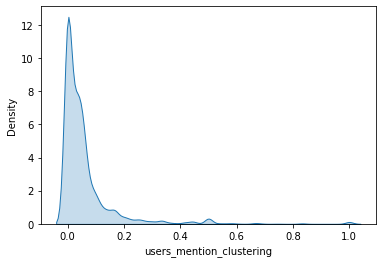

In [130]:
sns.kdeplot(users_mention_data["users_mention_clustering"], shade=True)

<AxesSubplot:xlabel='users_mention_eigenvector_in', ylabel='Density'>

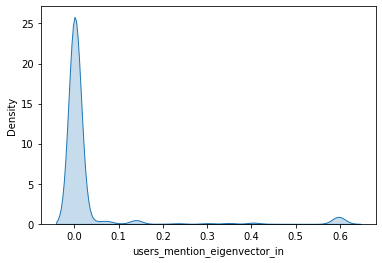

In [127]:
sns.kdeplot(users_mention_data["users_mention_eigenvector_in"], shade=True)

<AxesSubplot:xlabel='users_mention_eigenvector_out', ylabel='Density'>

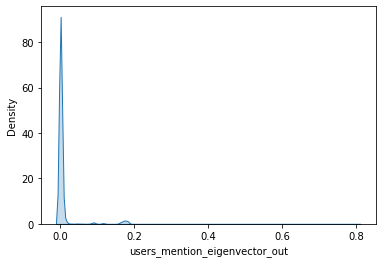

In [128]:
sns.kdeplot(users_mention_data["users_mention_eigenvector_out"], shade=True)

<AxesSubplot:xlabel='users_mention_in_degree', ylabel='Density'>

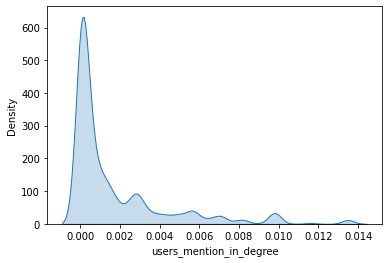

In [131]:
sns.kdeplot(users_mention_data["users_mention_in_degree"], shade=True)

<AxesSubplot:xlabel='users_mention_out_degree', ylabel='Density'>

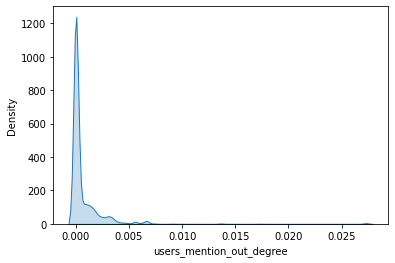

In [132]:
sns.kdeplot(users_mention_data["users_mention_out_degree"], shade=True)

<AxesSubplot:xlabel='users_mention_in_strength', ylabel='Density'>

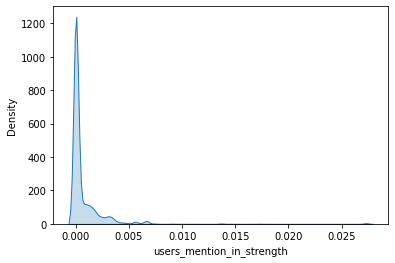

In [133]:
sns.kdeplot(users_mention_data["users_mention_in_strength"], shade=True)

<AxesSubplot:xlabel='users_mention_out_strength', ylabel='Density'>

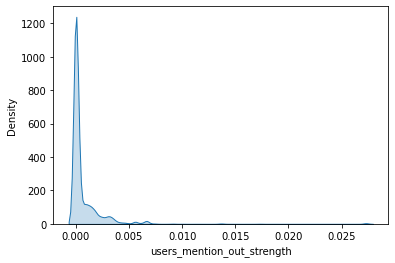

In [134]:
sns.kdeplot(users_mention_data["users_mention_out_strength"], shade=True)

## Users reply

In [92]:
users_reply_cols = [
    col for col in cols if col.startswith("users_reply")
    and not col.endswith("louvian_class")]
print(users_reply_cols)

['users_reply_in_degree', 'users_reply_out_degree', 'users_reply_in_strength', 'users_reply_out_strength', 'users_reply_eigenvector_in', 'users_reply_eigenvector_out', 'users_reply_katz_in', 'users_reply_katz_out', 'users_reply_clustering']


In [93]:
data_train[users_reply_cols].describe()

,users_reply_in_degree,users_reply_out_degree,users_reply_in_strength,users_reply_out_strength,users_reply_eigenvector_in,users_reply_eigenvector_out,users_reply_katz_in,users_reply_katz_out,users_reply_clustering
count,109589.000000,109589.000000,109589.000000,109589.000000,1.095890e+05,1.095890e+05,1.095890e+05,1.095890e+05,109589.000000
mean,0.000881,0.001735,14.023762,9.430049,1.489284e-02,1.496400e-02,1.496400e-02,1.496400e-02,0.021996
std,0.001478,0.003145,62.821257,36.913950,1.211210e-01,1.211114e-01,1.211114e-01,1.211114e-01,0.035695
min,0.000000,0.000000,0.000000,0.000000,-2.279486e-16,-8.583878e-17,-8.583878e-17,-8.583878e-17,0.000000
25%,0.000101,0.000203,1.000000,1.037037,-3.493149e-19,1.314064e-18,1.314064e-18,1.314064e-18,0.000000
50%,0.000405,0.000811,1.500000,1.578947,3.507677e-18,8.137703e-13,8.137703e-13,8.137703e-13,0.012000
75%,0.001115,0.001926,2.750000,2.666667,1.467539e-15,8.298867e-10,8.298867e-10,8.298867e-10,0.030864
max,0.019868,0.025038,433.666667,241.222222,9.999988e-01,9.999868e-01,9.999868e-01,9.999868e-01,1.000000


In [94]:
users_reply_data = data_train[users_reply_cols + ["retweet_label"]].dropna()
users_reply_data

,users_reply_in_degree,users_reply_out_degree,users_reply_in_strength,users_reply_out_strength,users_reply_eigenvector_in,users_reply_eigenvector_out,users_reply_katz_in,users_reply_katz_out,users_reply_clustering,retweet_label
134,0.000101,0.000608,1.0,1.166667,-7.068501e-19,5.453241e-16,5.453241e-16,5.453241e-16,0.0,0
136,0.000101,0.000608,1.0,1.166667,-7.068501e-19,5.453241e-16,5.453241e-16,5.453241e-16,0.0,0
137,0.000101,0.000608,1.0,1.166667,-7.068501e-19,5.453241e-16,5.453241e-16,5.453241e-16,0.0,1
140,0.000101,0.000608,1.0,1.166667,-7.068501e-19,5.453241e-16,5.453241e-16,5.453241e-16,0.0,0
141,0.000000,0.000101,0.0,1.000000,-1.806296e-18,3.593398e-19,3.593398e-19,3.593398e-19,0.0,0
...,...,...,...,...,...,...,...,...,...,...
173143,0.000101,0.003548,1.0,1.085714,-3.355206e-19,-3.886855e-19,-3.886855e-19,-3.886855e-19,0.0,0
173144,0.000101,0.003548,1.0,1.085714,-3.355206e-19,-3.886855e-19,-3.886855e-19,-3.886855e-19,0.0,0
173145,0.000101,0.003548,1.0,1.085714,-3.355206e-19,-3.886855e-19,-3.886855e-19,-3.886855e-19,0.0,0
173146,0.000101,0.000405,1.0,1.000000,-1.790319e-18,8.844931e-07,8.844931e-07,8.844931e-07,0.0,0


In [95]:
mi_scores = make_mi_scores(
    users_reply_data[users_reply_cols], users_reply_data["retweet_label"])
mi_scores

users_reply_out_strength       0.039609
users_reply_clustering         0.033461
users_reply_in_strength        0.033067
users_reply_out_degree         0.014894
users_reply_eigenvector_out    0.011937
users_reply_katz_out           0.011711
users_reply_katz_in            0.010840
users_reply_in_degree          0.008217
users_reply_eigenvector_in     0.002930
Name: MI Scores, dtype: float64

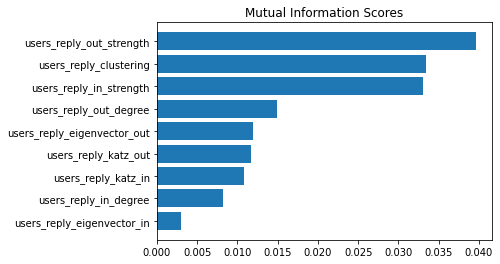

In [96]:
plot_mi_scores(mi_scores)

<AxesSubplot:xlabel='users_reply_out_strength', ylabel='Density'>

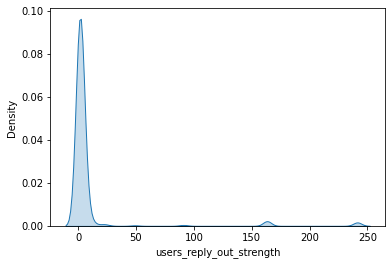

In [135]:
sns.kdeplot(users_reply_data["users_reply_out_strength"], shade=True)

<AxesSubplot:xlabel='users_reply_in_strength', ylabel='Density'>

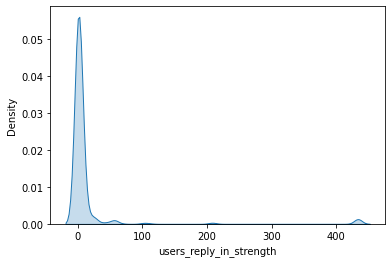

In [136]:
sns.kdeplot(users_reply_data["users_reply_in_strength"], shade=True)

<AxesSubplot:xlabel='users_reply_clustering', ylabel='Density'>

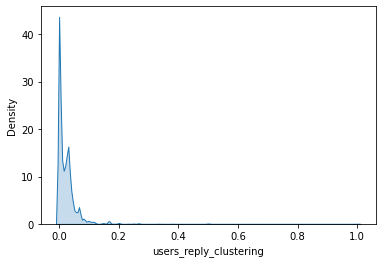

In [137]:
sns.kdeplot(users_reply_data["users_reply_clustering"], shade=True)

<AxesSubplot:xlabel='users_reply_out_degree', ylabel='Density'>

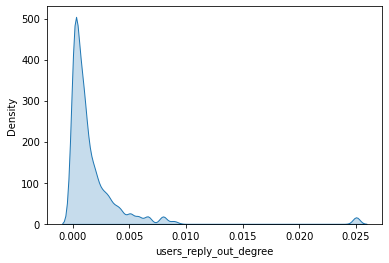

In [138]:
sns.kdeplot(users_reply_data["users_reply_out_degree"], shade=True)

<AxesSubplot:xlabel='users_reply_in_degree', ylabel='Density'>

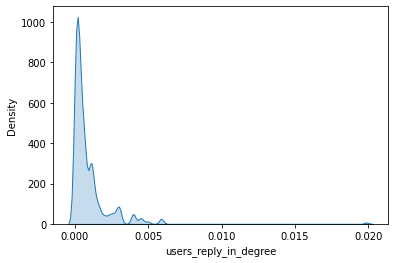

In [139]:
sns.kdeplot(users_reply_data["users_reply_in_degree"], shade=True)

<AxesSubplot:xlabel='users_reply_eigenvector_in', ylabel='Density'>

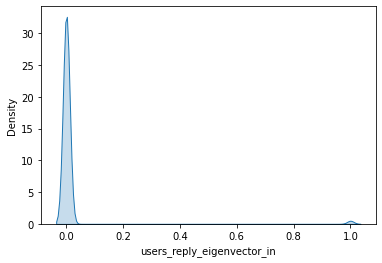

In [140]:
sns.kdeplot(users_reply_data["users_reply_eigenvector_in"], shade=True)

<AxesSubplot:xlabel='users_reply_eigenvector_out', ylabel='Density'>

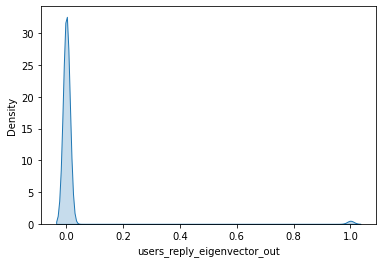

In [141]:
sns.kdeplot(users_reply_data["users_reply_eigenvector_out"], shade=True)

<AxesSubplot:xlabel='users_reply_katz_in', ylabel='Density'>

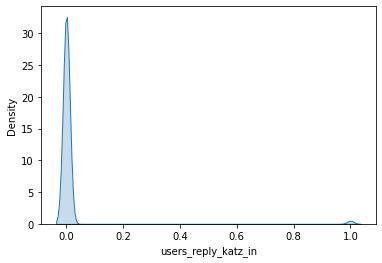

In [142]:
sns.kdeplot(users_reply_data["users_reply_katz_in"], shade=True)

<AxesSubplot:xlabel='users_reply_katz_out', ylabel='Density'>

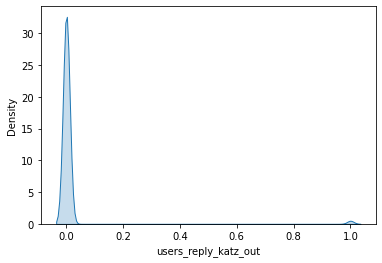

In [143]:
sns.kdeplot(users_reply_data["users_reply_katz_out"], shade=True)